In [399]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import collections
import random

In [300]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [400]:
df = pd.read_csv('train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [401]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Preprocessing

In [402]:
df.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)
df.loc[df['Age'].isnull(),'Age'] = np.round(df['Age'].mean())
df.loc[df['Embarked'].isnull(),'Embarked'] = df['Embarked'].value_counts().index[0]

In [403]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [404]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df['Survived'] = le.fit_transform(df['Survived']);
df['Sex'] = le.fit_transform(df['Sex'])
df['Embarked'] = le.fit_transform(df['Embarked'])

In [405]:
from sklearn.model_selection import train_test_split

X = df.copy()
Y = df['Survived']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
X_train = np.array(X_train)
X_test = np.array(X_test)

# Random Forest Algorithm

In [406]:
#bootstrap step of random forest, returns sampling(with replacement) of size n_samples 

def bootstrap(x_train,n_samples):
  
    bootstrap_indices = np.array((np.random.choice(range(len(x_train)),n_samples,replace = True))).flatten()
    samples = x_train[bootstrap_indices]
    return samples

In [407]:
# finds gini_impurity of the given node

def gini_impurity(left_split,right_split,class_values):
  
    left = len(left_split)
    right = len(right_split)
    left_split = np.array(left_split)
    right_split = np.array(right_split)
    n = left+right
    gini_1 = 0.0
    gini_2 = 0.0
    for i in class_values:
        prob1=0.0
        prob2=0.0
        if left:#if left node is not a leaf node
            prob1 = np.sum(left_split[:,0]==i)/left
        gini_1+=prob1**2
        if right:#if right node is not a leaf node
            prob2 = np.sum(right_split[:,0]==i)/right
        gini_2+=prob2**2
    gini_1 = 1-gini_1
    gini_2 = 1-gini_2
    gini_gain = (left/n)*gini_1 + (right/n)*gini_2
    return gini_gain

In [408]:
#returns the best possible split of a node

def get_split(dataset, n_features):
    
    dataset = np.array(dataset)
    features = np.random.choice(range(1,dataset.shape[1]),n_features) #selects n_features among all the features available . Note that we avoid choosing column 0 which contains the target value   
    class_values = np.unique(dataset[:,0])
    gini_score  = 1e5  # minimum Gini index
    b_index  = None  # index of best column
    b_value  = None  # best cut-off value of the best feature
    b_groups = None  # best left and right splits
    for i in features:
        for row in dataset:
            val = row[i]
            cond = dataset[:,i]<val
            left_split,right_split = (dataset[cond],dataset[~cond])
            gini_gain = gini_impurity(left_split,right_split,class_values)
            if gini_gain<gini_score:
                gini_score = gini_gain
                b_index = i
                b_val = val
                b_groups = (left_split,right_split)
    return {'index':b_index,'value':b_val,'groups':b_groups}

In [409]:
#performs the split operation of decision trees

def split(node, max_depth, min_size, n_features, depth):
  
    left,right = node['groups']
    del(node['groups'])
    left = np.array(left)
    right = np.array(right)
    if not len(left):#if left node is a leaf
        node['left'] = node['right'] = collections.Counter(right[:,0]).most_common()[0][0]
        return
    if not len(right):#if right node is a leaf
        node['left'] = node['right'] = collections.Counter(left[:,0]).most_common()[0][0]
        return

    if depth>=max_depth:#if the tree has reached maximum depth 
        node['left'] = collections.Counter(left[:,0]).most_common()[0][0]
        node['right'] = collections.Counter(right[:,0]).most_common()[0][0]
        return

    if len(left)<=min_size:#if the node has few samples
        node['left'] = collections.Counter(left[:,0]).most_common()[0][0]
    else:
        node['left'] = get_split(left,n_features)
        split(node['left'],max_depth,min_size,n_features,depth+1)

    if len(right)<=min_size:#if the node has few samples
        node['right'] = collections.Counter(right[:,0]).most_common()[0][0]
    else:
        node['right'] = get_split(right,n_features)
        split(node['right'],max_depth,min_size,n_features,depth+1)    

In [410]:
#returns the root node(which on recursing gives the entire tree) of the decision tree

def build_tree(train, max_depth, min_size, n_features):

    root = get_split(train, n_features)
    split(root, max_depth, min_size, n_features, 1)
    return root

In [411]:
#recursively determines the prediction of the decision tree

def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
              return predict(node['left'], row)
        else:
              return node['left']
    else:
        if isinstance(node['right'], dict):
              return predict(node['right'], row)
        else:
              return node['right']

In [412]:
#aggregation step of random forest; returns the predictions most common to all decision trees 

def bagging_predict(trees, row):
    predictions = np.array([predict(tree, row) for tree in trees])
    return collections.Counter(predictions).most_common()[0][0]

In [413]:
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
  # training
    trees = []
    for i in range(n_trees):
        sample = bootstrap(train,sample_size)
        sample = np.array(sample);
        tree = build_tree(sample, max_depth, min_size, n_features)
        trees.append(tree)
    # prediction
    predictions = [bagging_predict(trees, row) for row in test]
    return predictions

In [414]:
tree_list = np.append(1,np.arange(5,105,10)) # a list of probable number of trees to choose from

In [499]:
accuracies = []

for k in tree_list:
    predictions = random_forest(X_train,X_test,10,1,300,k,4)
    accuracies.append(np.sum(predictions==Y_test)/Y_test.shape[0])

We see that 35 trees produces the highest accuracy.We consider this for our test prediction.

In [500]:
accuracies

[0.7877094972067039,
 0.8100558659217877,
 0.8379888268156425,
 0.8435754189944135,
 0.8491620111731844,
 0.8324022346368715,
 0.8379888268156425,
 0.8379888268156425,
 0.8435754189944135,
 0.8379888268156425,
 0.8324022346368715]

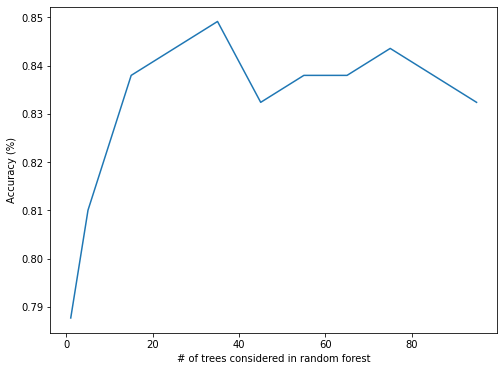

In [501]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(tree_list, accuracies)
ax.set_xlabel('# of trees considered in random forest')
ax.set_ylabel('Accuracy (%)');

# Test predictions

In [502]:
kaggel_test = pd.read_csv('test.csv')
k1 = kaggel_test.copy()
kaggel_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [503]:
kaggel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [504]:
kaggel_test.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)
kaggel_test.loc[kaggel_test['Age'].isnull(),'Age'] = np.round(kaggel_test['Age'].mean())
kaggel_test.loc[kaggel_test['Embarked'].isnull(),'Embarked'] = kaggel_test['Embarked'].value_counts().index[0]
kaggel_test.loc[kaggel_test['Fare'].isnull(),'Fare'] = kaggel_test['Fare'].mean()

In [505]:
kaggel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


In [506]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

kaggel_test['Sex'] = le.fit_transform(kaggel_test['Sex'])
kaggel_test['Embarked'] = le.fit_transform(kaggel_test['Embarked'])

In [507]:
zero = np.zeros(kaggel_test.shape[0])
kaggel_test.insert(0,'garbage_values',zero)# adding a column of garbage values just to meet dimension specifications. Note that this feature is never chosen 
kaggel_test = np.array(kaggel_test)
kaggel_test

array([[ 0.    ,  3.    ,  1.    , ...,  0.    ,  7.8292,  1.    ],
       [ 0.    ,  3.    ,  0.    , ...,  0.    ,  7.    ,  2.    ],
       [ 0.    ,  2.    ,  1.    , ...,  0.    ,  9.6875,  1.    ],
       ...,
       [ 0.    ,  3.    ,  1.    , ...,  0.    ,  7.25  ,  2.    ],
       [ 0.    ,  3.    ,  1.    , ...,  0.    ,  8.05  ,  2.    ],
       [ 0.    ,  3.    ,  1.    , ...,  1.    , 22.3583,  0.    ]])

In [509]:
predictions = random_forest(X_train,kaggel_test,10,1,300,35,4)

In [510]:
k1.insert(1,'Survived',predictions)
k1.drop(k1.columns[[2,3,4,5,6,7,8,9,10,11]],axis=1,inplace=True)

In [511]:
k1 # the final predictions for kaggle dataset

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,0.0
...,...,...
413,1305,0.0
414,1306,1.0
415,1307,0.0
416,1308,0.0


In [512]:
k1.to_csv('output.csv',index=False)